# Predicting Student Stats in a College

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
path = 'data/Student.csv'
df = pd.read_csv(path, sep=';')

df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


## Check for target variable balance

Imbalanced. **need to balance it later**

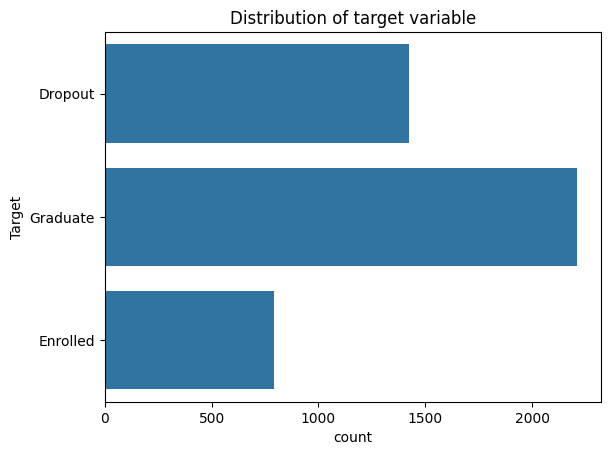

In [3]:
# visualize distribution of target variable 
# if the data is imbalanced, we should handle it
sns.countplot(y='Target', data=df)
plt.title('Distribution of target variable')
plt.show()

## Check for null values & Correlation between features

In [4]:
print(df.isnull().sum())
print('===============================')
print(df.info())

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

<Axes: >

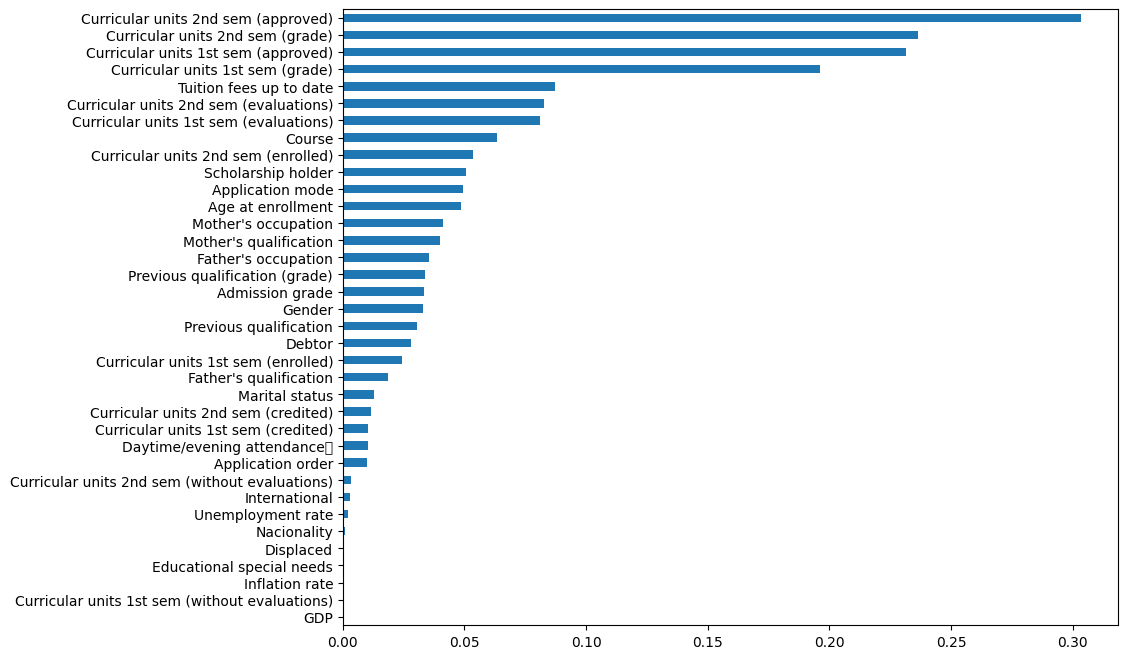

In [5]:
# check correlation between features

# temporarily encode categorical features to check correlation
df_temp = df.drop(columns=['Target']).copy()
for col in df_temp.select_dtypes(include=['object']):
    df_temp[col] = LabelEncoder().fit_transform(df_temp[col])

# calculate info gain
importances = mutual_info_classif(df_temp, LabelEncoder().fit_transform(df['Target']))

# display
feature_importances = pd.Series(importances, index=df_temp.columns)
plt.xlabel('Coefficient Value')
feature_importances.sort_values().plot(kind='barh', figsize=(10,8))

Features with high coefficient values are often a trap because they are too correlated to our target. The model will pratically only use them as a "God" feature and ignore the others. It will have a high accuracy but its not predicting, its just telling the present.

## Select features and target

In [6]:
# select features based on importance
features = [
    'Marital status',
    'Course',
    'Previous qualification',
    'Age at enrollment',
    'Scholarship holder',
    'Application mode',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'GDP']
target = 'Target'

# extract X and y
X = df[features]
y = df[target]

In [7]:
# help visualize the selected features
df[features].sample(5)

,Marital status,Course,Previous qualification,Age at enrollment,Scholarship holder,Application mode,Curricular units 1st sem (approved),Curricular units 1st sem (grade),GDP
1014,1,9147,1,20,1,18,5,11.800000,3.51
1669,1,8014,1,22,1,17,4,12.750000,0.79
3129,1,9773,1,18,1,1,6,12.666667,2.02
1895,1,9070,1,19,0,1,2,10.500000,0.32
838,1,9130,39,22,0,44,0,0.000000,-1.70


In [8]:
# separate categorical and numerical features - useful for encoding and scaling -.

# separate categorical features
cat_features = ['Marital status', 'Course', 'Previous qualification', 'Application mode', 'Scholarship holder']
X[cat_features] = X[cat_features].astype(str) # ensure categorical features are string type so we encode them properly

# automatically detect numerical features
num_features = [col for col in X.columns if col not in cat_features]

# Split and Feature Engineering

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Encode **Categorical** features

In [10]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# fit and transform training data
X_train_encoded = encoder.fit_transform(X_train[cat_features])
# transform test data
X_test_encoded = encoder.transform(X_test[cat_features])

## Encode target (optional in DT)

In [11]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


## Scale Numerical Features (NOT needed in DT)

## Concat Categorical and Numerical Features

In [12]:
# check whether the number of rows match (it has to in order to use hstack)
print(len(X_train) == len(X_train_encoded))

True


In [13]:
X_train_final = np.hstack([X_train[num_features], X_train_encoded])
X_test_final = np.hstack([X_test[num_features], X_test_encoded])

In [14]:
print(f"Final shape of training data: {X_train_final.shape}")

Final shape of training data: (3539, 59)


# Train our model

In [15]:
decisionTree = DecisionTreeClassifier(criterion='entropy' ,class_weight='balanced', max_depth=4, random_state=42)

decisionTree.fit(X_train_final, y_train_encoded)

# make predictions
tree_pred = decisionTree.predict(X_test_final)

In [16]:
# visualize accuracy
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test_encoded, tree_pred))

Decision Trees's Accuracy:  0.631638418079096


## Classification report

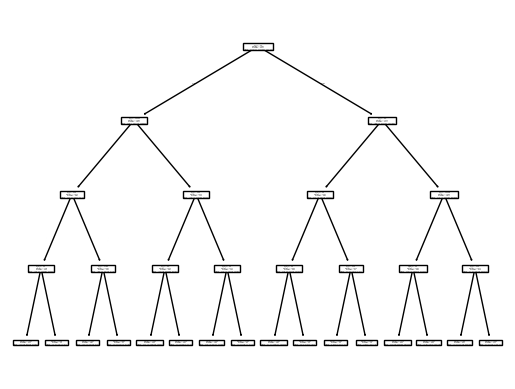

In [17]:

# visualize tree
plot_tree(decisionTree)
plt.show()
